In [ ]:
import os
import math
import random
import warnings
from collections import Counter
from itertools import combinations

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torchvision
from torchvision import models, transforms
from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# compute device once
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# immutable dataset root
DATASET_ROOT = '/kaggle/input/journey-springfield'
train_path = f"{DATASET_ROOT}/train/simpsons_dataset/"


In [ ]:
class_names = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
num_classes = len(class_names)

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 224, 224, 3
img_size = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

print(f"num classes: {num_classes}")

num classes:  42


In [ ]:
# map integer index to class name (stable ordering)
enc = {index: name for index, name in enumerate(class_names)}

In [ ]:
augmenters = {
    'geom_combo': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=16),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    ]),
    'rotate_only': transforms.RandomRotation(degrees=(-25, 25)),
    'hflip_only': transforms.RandomHorizontalFlip(p=1.0),
}

In [ ]:
labels, images = [], []
class_count = {}
print('images:\n')
for class_name in class_names:
    print(class_name, end=' -> ')
    class_dir = os.path.join(train_path, class_name)
    num_in_class = len(os.listdir(class_dir))
    class_count[class_name] = num_in_class
    iterations = (1000 - num_in_class) // num_in_class
    print(num_in_class)

    class_index = class_names.index(class_name)
    one_hot = np.eye(num_classes, dtype=np.float32)[class_index]

    for _, file_name in enumerate(os.listdir(class_dir)):
        path = os.path.join(class_dir, file_name)
        img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
        img_rgb = cv2.resize(img_bgr, (224, 224))[:, :, ::-1]
        pil_img = Image.fromarray(np.asarray(img_rgb))

        images.append(pil_img)
        labels.append(one_hot)

        if iterations < 1:
            continue
        for _ in range(iterations):
            augmenter = random.choice(list(augmenters.values()))
            images.append(augmenter(pil_img))
            labels.append(one_hot)

labels = np.asarray(labels)
images = np.asarray(images)

print(f"\n\nlabels shape: {labels.shape}")
print(f"images shape: {images.shape}")


images:

abraham_grampa_simpson -> 913
agnes_skinner -> 42
apu_nahasapeemapetilon -> 623
barney_gumble -> 106
bart_simpson -> 1342
carl_carlson -> 98
charles_montgomery_burns -> 1193
chief_wiggum -> 986
cletus_spuckler -> 47
comic_book_guy -> 469
disco_stu -> 8
edna_krabappel -> 457
fat_tony -> 27
gil -> 27
groundskeeper_willie -> 121
homer_simpson -> 2246
kent_brockman -> 498
krusty_the_clown -> 1206
lenny_leonard -> 310
lionel_hutz -> 3
lisa_simpson -> 1354
maggie_simpson -> 128
marge_simpson -> 1291
martin_prince -> 71
mayor_quimby -> 246
milhouse_van_houten -> 1079
miss_hoover -> 17
moe_szyslak -> 1452
ned_flanders -> 1454
nelson_muntz -> 358
otto_mann -> 32
patty_bouvier -> 72
principal_skinner -> 1194
professor_john_frink -> 65
rainier_wolfcastle -> 45
ralph_wiggum -> 89
selma_bouvier -> 103
sideshow_bob -> 877
sideshow_mel -> 40
snake_jailbird -> 55
troy_mcclure -> 8
waylon_smithers -> 181


labels shape: (44110, 42)
images shape: (44110, 224, 224, 3)


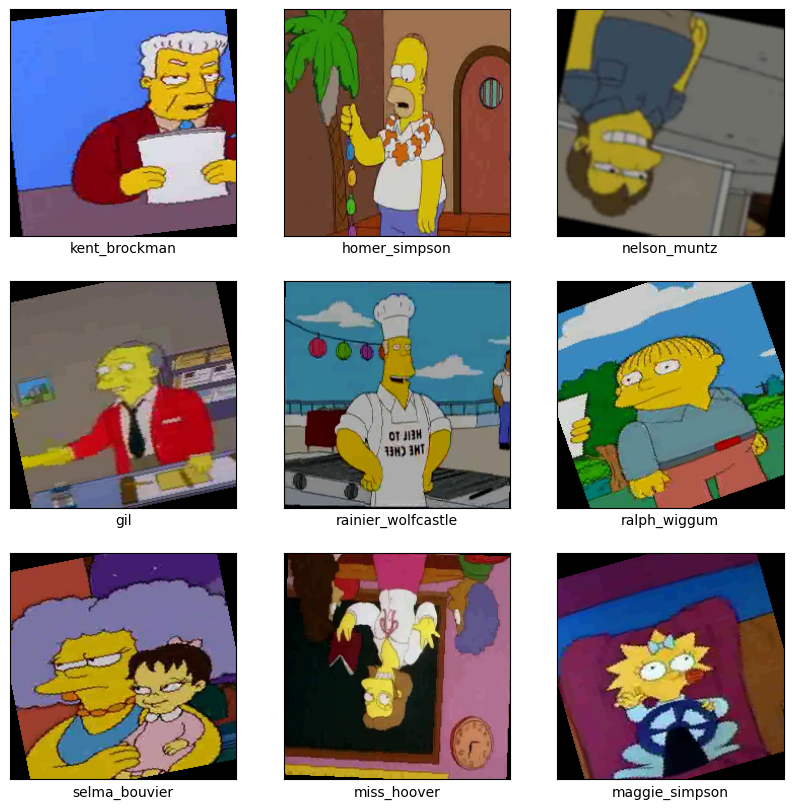

In [ ]:
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

for row in range(rows):
    for col in range(cols):
        index = random.randrange(0, len(images))
        axs[row][col].imshow(images[index])
        axs[row][col].set_xticks([])
        axs[row][col].set_yticks([])
        axs[row][col].set_xlabel(class_names[int(np.argmax(labels[index]))])

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.1, random_state=42, shuffle=True
)

y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
print('done')

done


In [ ]:
class DataSet():

  def __init__(self, images, labels=None, transform=None):
    self.image = images
    self.label = labels
    self.transform = transform

  def __getitem__(self, index):
      image = self.image[index]
      if self.transform is not None:
          image = self.transform(image)
      return image, self.label[index]

  def __len__(self):
    return len(self.image)

In [ ]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 80
LEARNING_RATE = 3e-4
PATIENCE = 5

In [ ]:
dataset_train = DataSet(X_train, y_train, image_transform)
dataset_val = DataSet(X_val, y_val, image_transform)

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = models.efficientnet_v2_s(weights=weights)
num_features = model.classifier[1].in_features
model.classifier = nn.Linear(num_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 181MB/s] 


In [ ]:
def check_score(loader, model, device="cuda"):
    total_loss = 0.0
    total_f1 = 0.0
    with torch.no_grad():
        for images_batch, labels_batch in tqdm(loader):
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            labels_idx = torch.argmax(labels_batch, dim=1)
            logits = model(images_batch)
            predictions = torch.argmax(logits, dim=1)
            loss = criterion(logits, labels_idx)
            total_loss += loss.item()
            total_f1 += f1_score(labels_idx.cpu(), predictions.cpu(), average='macro')
        final_f1 = total_f1 / len(loader)
        avg_loss = total_loss / len(loader)
    return final_f1, avg_loss

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

val_losses, train_losses = [], []
val_f1, train_f1 = [], []
best_loss = float('inf')
patience_counter = 0

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for batch_images, batch_labels in train_loader:
        inputs = batch_images.to(device)
        targets = batch_labels.to(device)
        logits = model(inputs)
        loss = criterion(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    f1_train, loss_train = check_score(train_loader, model)
    f1_val, loss_val = check_score(val_loader, model)

    train_losses.append(loss_train)
    val_losses.append(loss_val)
    train_f1.append(f1_train)
    val_f1.append(f1_val)

    scheduler.step(loss_val)
    print(f"epoch: {epoch} Got f1 score: {f1_val} and loss: {loss_val:.2f}")

    if loss_val < best_loss:
        best_loss = loss_val
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= PATIENCE:
        break

100%|██████████| 69/69 [00:16<00:00,  4.19it/s]

epoch: 0 Got f1 score: 0.9651914537301148 and loss: 0.09



100%|██████████| 69/69 [00:16<00:00,  4.20it/s]

epoch: 1 Got f1 score: 0.9789870300648394 and loss: 0.06



100%|██████████| 69/69 [00:16<00:00,  4.18it/s]

epoch: 2 Got f1 score: 0.9843614020447753 and loss: 0.05



100%|██████████| 69/69 [00:16<00:00,  4.20it/s]

epoch: 3 Got f1 score: 0.9857857313001394 and loss: 0.04



100%|██████████| 69/69 [00:16<00:00,  4.20it/s]

epoch: 4 Got f1 score: 0.9859960961419942 and loss: 0.07



100%|██████████| 69/69 [00:16<00:00,  4.20it/s]

epoch: 5 Got f1 score: 0.9869722401257705 and loss: 0.05


In [ ]:
plt.figure(figsize=(10, 5))
# losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# f1 scores
plt.subplot(1, 2, 2)
plt.plot(train_f1, label='Train f1 score')
plt.plot(val_f1, label='Val f1 score')
plt.title('f1 score vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('f1 score')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
submit = pd.read_csv(f"{DATASET_ROOT}/sample_submission.csv")
test_path = f"{DATASET_ROOT}/testset/testset/"

images_test = []
for index in range(991):
    img_path = os.path.join(test_path, f"img{index}.jpg")
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.resize(img_bgr, (224, 224))[:, :, ::-1]
    images_test.append(np.asarray(img_rgb))

predict_list = []
model.eval()
with torch.no_grad():
    for img in images_test:
        out = model(image_transform(img).unsqueeze(0).to(device))
        predicted = torch.argmax(out, dim=1).cpu().item()
        predict_list.append(enc.get(predicted))

In [ ]:
submit['Expected'] = predict_list
submit.to_csv('submission.csv', index=False)